### Training an LLM

1. Iterate over training epochs (one epoch is a complete pass over a training set).
2. Iterate over batches in each training epoch (# of batches = training set size / size of each batch).
3. Reset loss gradients from previous batch iteration.
4. Calculate loss on current batch.
5. Backward pass to calculate loss gradients. 
6. Update model weights using loss gradients. 
7. Print training and validation set losses.
8. Generate sample text for visual inspection.

In [1]:
import torch
from Chapter04 import GPTModel, create_dataloader_v1, generate_text_simple
from Chapter05 import calc_loss_batch, calc_loss_loader, text_to_token_ids, token_ids_to_text, tokeniser

GPT_CONFIG_124M = {
    "vocab_size": 50_257,
    "context_length": 256, # shortened from 1,024
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

In [2]:
# Read in short story again
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [3]:
# Split dataset into train/validation sets
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
test_data = text_data[split_idx:]

In [4]:
# Create respective data loaders
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

test_loader = create_dataloader_v1(
    test_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [5]:
# Step 7
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # dropout is disabled for stable, reproducible results
    with torch.no_grad(): # disables gradient tracking
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [6]:
# Step 8
def generate_and_print_sample(model, tokeniser, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokeniser).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, 
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokeniser)
    print(decoded_text.replace("\n", " "))
    model.train()

In [7]:
def train_model_simple(model, train_loader, val_loader,
                       optimiser, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokeniser):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs): # step 1
        model.train()
        for input_batch, target_batch in train_loader: # step 2
            optimiser.zero_grad() # step 3
            loss = calc_loss_batch( # step 4
                input_batch, target_batch, model, device
            )
            loss.backward() # step 5
            optimiser.step() # step 6
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0: # step 7
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample( # step 8
            model, tokeniser, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


We use AdamW as our optimiser. It is a variant of Adam that improves the weight decay approach, which aims to minimise model complexity and prevent overfitting by penalising larger weights. This adjustment allows AdamW to achieve more effective regularisation and better generalisation. 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimiser = torch.optim.AdamW(
    model.parameters(), # return all trainable weight parameters of the model
    lr=0.0004,
    weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, test_loader, optimiser, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokeniser=tokeniser
)

Epoch 1 (Step 000000): Train loss 9.840, Val loss 10.090
Epoch 1 (Step 000005): Train loss 8.254, Val loss 8.252
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Epoch 2 (Step 000010): Train loss 6.723, Val loss 7.038
Epoch 2 (Step 000015): Train loss 6.107, Val loss 6.575
Every effort moves you, the, the, the, the, the, the, the.                                   
Epoch 3 (Step 000020): Train loss 5.534, Val loss 6.434
Epoch 3 (Step 000025): Train loss 5.581, Val loss 6.437
Every effort moves you, and and, and a a . . . a a a of the and a, and a, and, and, and, and, and, and the of the of the of the of the of the and a, and, and,
Epoch 4 (Step 000030): Train loss 5.100, Val loss 6.477
Epoch 4 (Step 000035): Train loss 4.914, Val loss 6.452
Every effort moves you in the picture. Gisburn's't to me to a me. Gisburn was no's--I"I had been to me to me to me his pictures he had been his painting his a _ a to me to me to me
Epoch 5 (Step 000040): Train loss 4.696, 

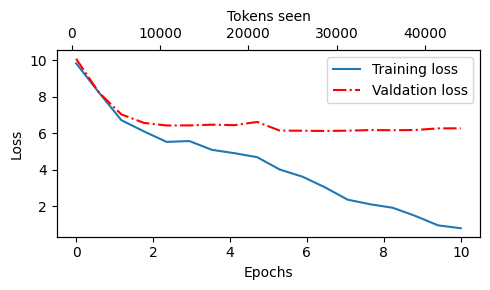

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Valdation loss", color='red')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

As can be seen above, both the training and validation losses start to improve but then diverge past the second epoch. This divergence and the fact the validation loss is far higher than the training loss indicate that the model is overfitting to the training data. This memorisation is expected since we have a very small dataset and train the model for multiple epochs. It's not uncommon to train a much larger dataset for only one epoch. 

### Decoding strategies to control randomness

There are techniques to generate more original text, two of which are <i>temperature scaling</i> and <i>top-k sampling</i>.

In [ ]:
# Inference with a small model doesn't need a GPU; also turn off random components
model.to("cpu")
model.eval()

In [11]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokeniser),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokeniser))

Output text:
 Every effort moves you know," was one of the picture for nothing--I told Mrs.

"Once, when I looked up, I


The generated token is selected at each generation step corresponding to the largest probability score among all tokens in the vocab. This means the LLM will always generate the same output even if we run the function on the same start context. 

#### Temperature scaling

This is a technique that adds a probabilistic selection process to the next-token generation task. Selecting the token with the highest probability is known as <i>greedy decoding</i>. To generate with more variety, we can instead use a function that samples from a probability distribution. A contrived example is shown below.

In [12]:
# Small vocab
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [13]:
# Assume the model generates the following logits
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


The largest logit value and correspondingly the largest softmax probability is the word "forward". To implement a probabilistic sampling process, we replace argmax with the multinomial function. This function samples the next token proportional to its probability score. "Forward" is still the most likely token and will be selected by multinomial most of the time, but not all the time.

In [14]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [15]:
# Check what happens when sampled 1,000 times
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
              for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


We can further control the distribution and selection process via temperature scaling. This means we divide the logits by a number greater than 0. Temperatures greater than 1 result in more uniformly distributed token probabilities (we get more creative but also potentially nonsensical outputs), while temperatures less than 1 will result in more confident (sharper) distributions. 

In [16]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

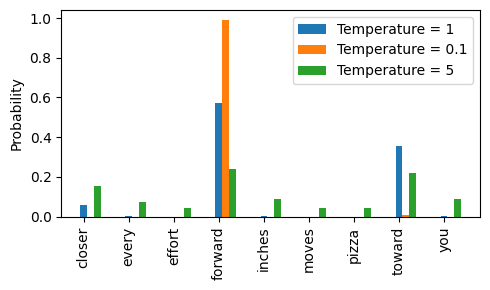

In [17]:
temperatures = [1, 0.1, 5] # original, lower, and higher temperatures
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                 for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f"Temperature = {T}")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

#### Top-k sampling

One disadvantage of temperature scaling is that it sometimes leads to grammatically incorrect or nonsensical outputs such as "every effort moves you pizza". Top-k sampling, when combined with probabilistic sampling and temperature scaling, can improve the text generation results. Here, we restrict the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process by masking their probability scores (with a negative infinity value). The remaining probabilities will sum up to 1. 

In [18]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [19]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], # identifies logits less than the minimum in top 3
    input=torch.tensor(float('-inf')), # assigns -inf to these lower logits
    other=next_token_logits # retains original logits for other tokens
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [20]:
# Lastly, we apply the softmax function
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


#### Modifying the text generation function

In [21]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float("-inf")).to(logits.device),
                logits
            )
    
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
    
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [22]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokeniser),
    max_new_tokens=20,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokeniser))

Output text:
 Every effort moves you know began to happen a hint one of it was such a good fellow enough--so it was no


### Loading and saving model weights in PyTorch

In [23]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
# Load the model
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

model.eval() switches the model into inference mode for inference, disabling the dropout layers of the model. If we plan to continue pretraining a model later, saving the optimiser state is also recommended. Adaptive optimisers like AdamW store additional parameters for each model weight - it uses historical data to adjust learning rates for each model parameter dynamically. Without it, the optimiser resets, and the model may learn suboptimally or even fail to converge properly. 

In [24]:
# Save both the model and optimiser state dict contents
torch.save({
    "model_state_dict": model.state_dict(),
    "optimiser_state_dict": optimiser.state_dict()
    },
    "model_and_optimiser.pth"
)

In [ ]:
# Restore model and optimiser states
checkpoint = torch.load("model_and_optimiser.pth", map_location=device)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimiser = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimiser.load_state_dict(checkpoint["optimiser_state_dict"])
model.train()